In [1]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests
from statsmodels.regression.mixed_linear_model import MixedLM

import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u

ko_mice = stx.ymaze_sess_deets.ko_vr_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_vr_mice
plt.rcParams['pdf.fonttype']=42

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [11]:
fig_dir = "C:/Users/esay/data/Stx3/fig_scratch/behavior"
os.makedirs(fig_dir,exist_ok=True)
dt = 15.46

In [4]:
sparse_mice = stx.ymaze_sess_deets.sparse_mice
# sparse_mice = sparse_mice[3:]


In [5]:
print(sparse_mice)

('SparseKO_06', 'SparseKO_08', 'SparseKO_09', 'SparseKO_10', 'SparseKO_11', 'SparseKO_13')


In [10]:
def correct_lick_sensor_error(licks_, trial_starts, trial_ends, correction_thr=0.5):
    """
    Find samples where lick detector was putatively stuck at 1, and set to NaN

    :param licks_:
    :type licks_:
    :param trial_starts:
    :type trial_starts:
    :param trial_ends:
    :type trial_ends:
    :param correction_thr:
    :type correction_thr:
    :return:
    :rtype:
    """
    licks = np.copy(licks_)
    error_count = 0
    for t_start, t_end in zip(trial_starts, trial_ends):
        # if >50% of samples have a cumulative lick count of >2
        # print(sum(licks[t_start:t_end]>2))
        if sum(licks[t_start:t_end] > 0)/len(licks[t_start:t_end]) > correction_thr:
            licks[t_start:t_end] = 0
            # print(f'setting trial {np.where(trial_starts==t_start)[0]} to NaN')
            error_count += 1

    return licks, error_count

### Definitions of sess.trial_matrices['licks']

Note sess.trial_matrices['licks'] is not lick count per spatial bin or lick rate!  \
sess.trial_matrices['licks'][0] # is the mean number of licks per spatial bin  \
sess.trial_matrices['licks'][1] # is the time occupancy per spatial bin / fraction of occupied bins??  \
sess.trial_matrices['licks'][2] # is the spatial bin edges  \
sess.trial_matrices['licks'][3] # is the spatial bin centers

{'date': '25_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 0, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_121288\4231049737.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('winter')
C:\Users\esay\AppData\Local\Temp\ipykernel_121288\4231049737.py:16: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  mat = sp.ndimage.filters.gaussian_filter1d(mat,1,axis=1)


Text(0.5, 1.0, 'SparseKO_09')

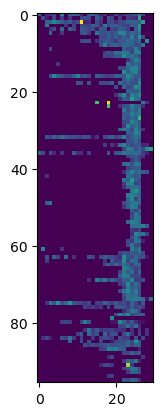

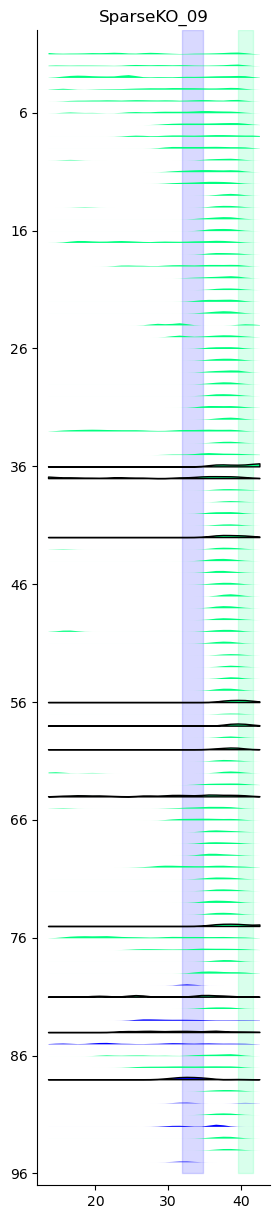

In [9]:
sess = u.load_vr_day(sparse_mice[2],0)

sess.add_timeseries(rewards=sess.vr_data['reward'])
sess.add_pos_binned_trial_matrix('rewards')

omis = ~(np.nansum(sess.trial_matrices['rewards'],axis=-1)>0)
fig,ax = plt.subplots()
ax.imshow(sess.trial_matrices['licks'])

fig, ax = plt.subplots(figsize=[3,15])
x = sess.trial_matrices['bin_centers']
cm = plt.cm.get_cmap('winter')
lr = sess.trial_info['LR']
mat = sess.trial_matrices['licks']
# mat[np.isnan(mat)] = 0
mat = sp.ndimage.filters.gaussian_filter1d(mat,1,axis=1)
# mat/=np.amax(mat,axis=1,keepdims=True)*1.4
# mat = filters.gaussian_filter1d(sess.trial_matrices['licks'], sig, axis=1)

for ind, i in enumerate(np.arange(mat.shape[0] - 1, 0, -1)):
    if omis[ind]:
        ax.fill_between(x, mat[ind, :] + i, y2=i, color=cm(np.float64(lr[ind])), edgecolor='black')
    else:
        ax.fill_between(x, mat[ind, :] + i, y2=i, color=cm(np.float64(lr[ind])), linewidth=.001)
        

ax.fill_betweenx([0,lr.shape[0]+1],31.9,34.8,color=plt.cm.winter(0.),alpha=.15,zorder=0)
ax.fill_betweenx([0,lr.shape[0]+1],39.5,41.6,color=plt.cm.winter(1.),alpha=.15,zorder=0)

ax.set_yticks(np.arange(0, mat.shape[0], 10))
ax.set_yticklabels(["%d" % i for i in np.arange(mat.shape[0], 0, -10).tolist()])
ax.set_ylim([-1,lr.shape[0]+1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title(sess.mouse)

# fig.savefig(os.path.join(figdir,"single_sess_licks","Licks_%s_%s.pdf" % (sess.mouse,sess.date)))

In [13]:
sparse_mice

('SparseKO_06',
 'SparseKO_08',
 'SparseKO_09',
 'SparseKO_10',
 'SparseKO_11',
 'SparseKO_13')

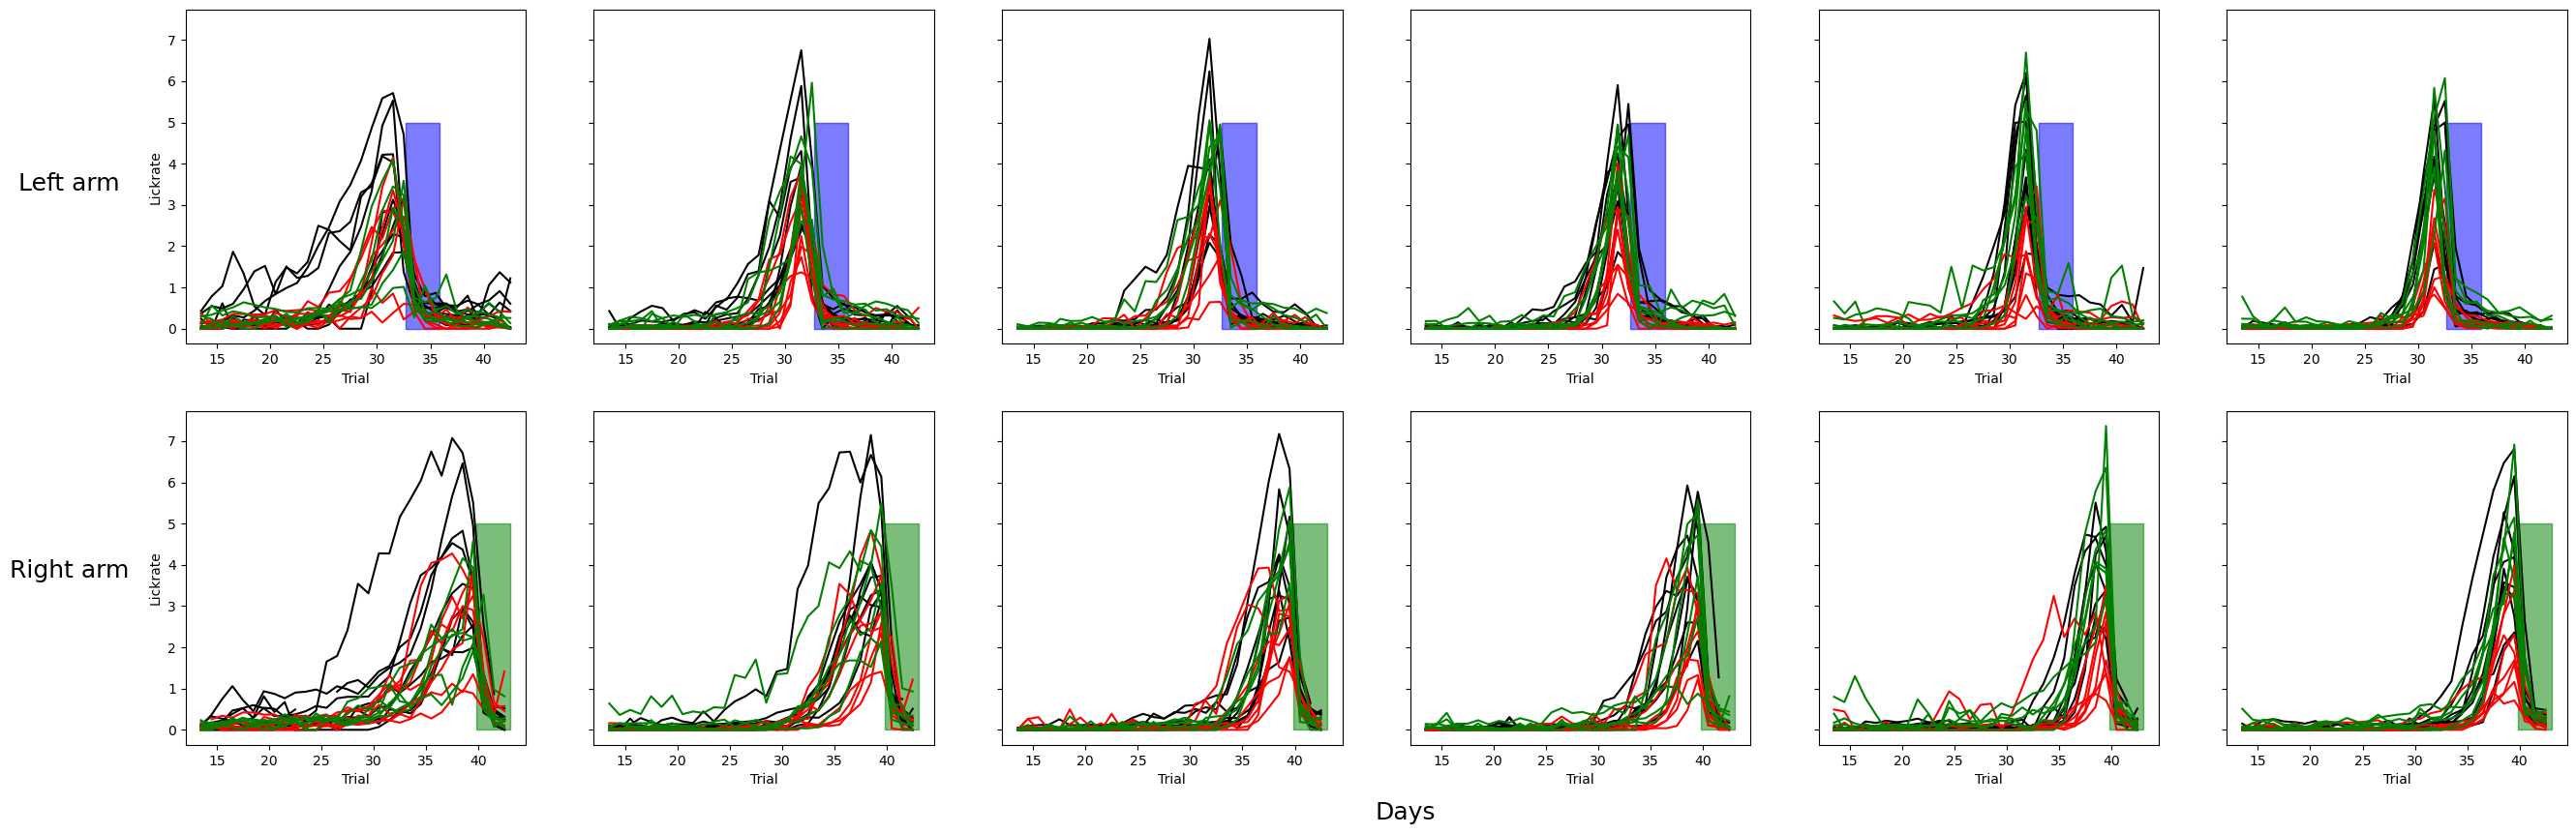

In [53]:
fig, ax = plt.subplots(2,6,figsize=[30,10], sharey=True)

ko_lr = {}
ctrl_lr = {}
sparse_lr = {}


for day in range(6):
    
    ctrl_lr[day]={'left':[],'right':[]}
    
    for i, mouse in enumerate(ctrl_mice):
        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','speed'),verbose = False)
        
        ax[0,day].plot(sess.trial_matrices['bin_centers'], dt*sess.trial_matrices['licks'][sess.trial_info['LR']==-1,:].mean(axis=0),color='black')
        ax[1,day].plot(sess.trial_matrices['bin_centers'], dt*sess.trial_matrices['licks'][sess.trial_info['LR']==1,:].mean(axis=0),color='black')
        
        if i == 0:
            ax[1,day].fill_betweenx([0,5], sess.rzone_late['tfront'], sess.rzone_late['tback'],zorder=0, color='green',alpha=.3)
            ax[0,day].fill_betweenx([0,5],sess.rzone_early['tfront'], sess.rzone_early['tback'],zorder=0, color='blue',alpha=.3)
            
            t_bins = sess.trial_matrices['bin_edges'][1:]
            rzone_early = (t_bins>=sess.rzone_early['tfront']-3)*(t_bins<=sess.rzone_early['tfront'])
            rzone_late = (t_bins>=sess.rzone_late['tfront']-3)*(t_bins<=sess.rzone_late['tfront'])
            
        ctrl_lr[day]['left'].append(dt*np.nanmean(sess.trial_matrices['licks'][sess.trial_info['LR']==-1,:][:,rzone_early]))
        ctrl_lr[day]['right'].append(dt*np.nanmean(sess.trial_matrices['licks'][sess.trial_info['LR']==1,:][:,rzone_late]))
        
    ko_lr[day]={'left':[],'right':[]}
    
    for i, mouse in enumerate(ko_mice):
        try:
            sess = u.load_vr_day(mouse,day, verbose=False)
            trial_mask = sess.trial_info['LR']==-1
            if day==0 and i == 3:
                trial_mask[35:66]=False

            ax[0,day].plot(sess.trial_matrices['bin_centers'], dt*sess.trial_matrices['licks'][trial_mask,:].mean(axis=0),color='red')
            ax[1,day].plot(sess.trial_matrices['bin_centers'], dt*sess.trial_matrices['licks'][sess.trial_info['LR']==1,:].mean(axis=0),color='red')

            ko_lr[day]['left'].append(dt*np.nanmean(sess.trial_matrices['licks'][trial_mask,:][:,rzone_early]))
            ko_lr[day]['right'].append(dt*np.nanmean(sess.trial_matrices['licks'][sess.trial_info['LR']==1,:][:,rzone_late]))
        except:
            pass
            
    sparse_lr[day]={'left':[],'right':[]}
    
    for i, mouse in enumerate(sparse_mice):
        if day == 2 and mouse =="SparseKO_09":
            continue
        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','speed'),verbose = False)
        
        ax[0,day].plot(sess.trial_matrices['bin_centers'], dt*sess.trial_matrices['licks'][sess.trial_info['LR']==-1,:].mean(axis=0),color='green')
        ax[1,day].plot(sess.trial_matrices['bin_centers'], dt*sess.trial_matrices['licks'][sess.trial_info['LR']==1,:].mean(axis=0),color='green')
        
        if i == 0:
            ax[1,day].fill_betweenx([0,5], sess.rzone_late['tfront'], sess.rzone_late['tback'],zorder=0, color='green',alpha=.3)
            ax[0,day].fill_betweenx([0,5],sess.rzone_early['tfront'], sess.rzone_early['tback'],zorder=0, color='blue',alpha=.3)
            
            t_bins = sess.trial_matrices['bin_edges'][1:]
            rzone_early = (t_bins>=sess.rzone_early['tfront']-3)*(t_bins<=sess.rzone_early['tfront'])
            rzone_late = (t_bins>=sess.rzone_late['tfront']-3)*(t_bins<=sess.rzone_late['tfront'])
            
        sparse_lr[day]['left'].append(dt*np.nanmean(sess.trial_matrices['licks'][sess.trial_info['LR']==-1,:][:,rzone_early]))
        sparse_lr[day]['right'].append(dt*np.nanmean(sess.trial_matrices['licks'][sess.trial_info['LR']==1,:][:,rzone_late]))

        ax[0,day].set_xlabel("Trial")
        ax[1,day].set_xlabel("Trial")

ax[0,0].set_ylabel('Lickrate')
ax[1,0].set_ylabel("Lickrate")
fig.text(0.04, 0.70, 'Left arm',va='center',ha='center', rotation='horizontal', fontsize=18)
fig.text(0.04, 0.30, 'Right arm',va='center',ha='center', rotation='horizontal', fontsize=18)
fig.text(0.5, 0.05, 'Days',va='center',ha='center', rotation='horizontal', fontsize=18)
fig.subplots_adjust(wspace=0.2, hspace=0.2, left=0.08, bottom = 0.12)
        # except:
        #     pass

left day 0: t:0.129099, p:0.897279
left day 0: t2:1.532065, p2:0.125506
right day 0: t:0.645497, p:0.518605
right day 0: t2:1.649916, p2:0.098960
left day 1: t:-1.678293, p:0.093290
left day 1: t2:0.235702, p2:0.813664
right day 1: t:-1.420094, p:0.155580
right day 1: t2:0.824958, p2:0.409395
left day 2: t:-2.781315, p:0.005414
left day 2: t2:-0.733333, p2:0.463355
right day 2: t:-2.049390, p:0.040424
right day 2: t2:-0.466667, p2:0.640738
left day 3: t:-2.711088, p:0.006706
left day 3: t2:0.235702, p2:0.813664
right day 3: t:-1.032796, p:0.301700
right day 3: t2:0.824958, p2:0.409395
left day 4: t:-3.098387, p:0.001946
left day 4: t2:-0.235702, p2:0.813664
right day 4: t:-2.840188, p:0.004509
right day 4: t2:-0.235702, p2:0.813664
left day 5: t:-2.581989, p:0.009823
left day 5: t2:0.235702, p2:0.813664
right day 5: t:-3.098387, p:0.001946
right day 5: t2:-0.235702, p2:0.813664


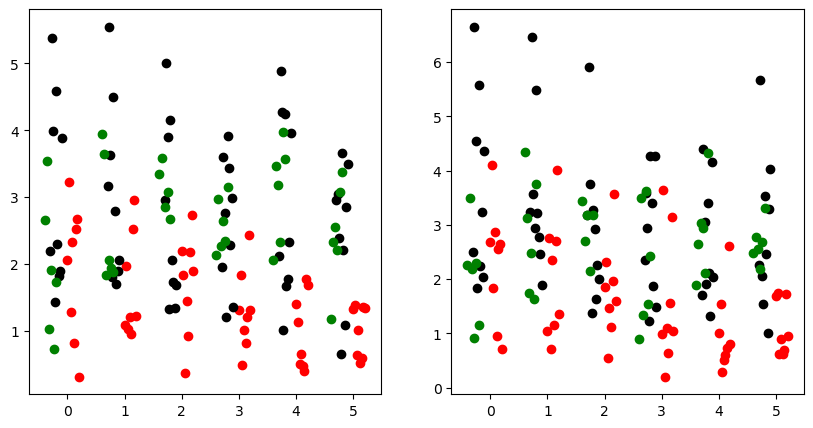

In [17]:
fig, ax = plt.subplots(1,2, figsize=[10,5])

for day in range(6):
    for ax_ind, lr in enumerate(('left', 'right')):
    
        ko = np.array(ko_lr[day][lr])
        ax[ax_ind].scatter(np.linspace(day,day+.2, num = ko.shape[0]),ko, color='red')

        ctrl = np.array(ctrl_lr[day][lr])
        ax[ax_ind].scatter(np.linspace(day-.3, day-.1, num = ctrl.shape[0]),ctrl, color='black')

        sparse = np.array(sparse_lr[day][lr])
        ax[ax_ind].scatter(np.linspace(day-.4, day-.2, num = sparse.shape[0]),sparse, color='green')
        
    #     print(ko,ctrl)
        t,p = sp.stats.ranksums(ko,sparse)
        print("%s day %d: t:%f, p:%f" % (lr, day,t,p))

        t2,p2 = sp.stats.ranksums(ctrl,sparse)
        print("%s day %d: t2:%f, p2:%f" % (lr, day,t2,p2))

C:\Users\esay\AppData\Local\Temp\ipykernel_121288\2822713269.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lick = df_lick.append({'mouse': mouse,
C:\Users\esay\AppData\Local\Temp\ipykernel_121288\2822713269.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lick = df_lick.append({'mouse': mouse,
C:\Users\esay\AppData\Local\Temp\ipykernel_121288\2822713269.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lick = df_lick.append({'mouse': mouse,
C:\Users\esay\AppData\Local\Temp\ipykernel_121288\2822713269.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lick = df_lick.append({'mouse': mouse,
C:\Users\esay\AppDat

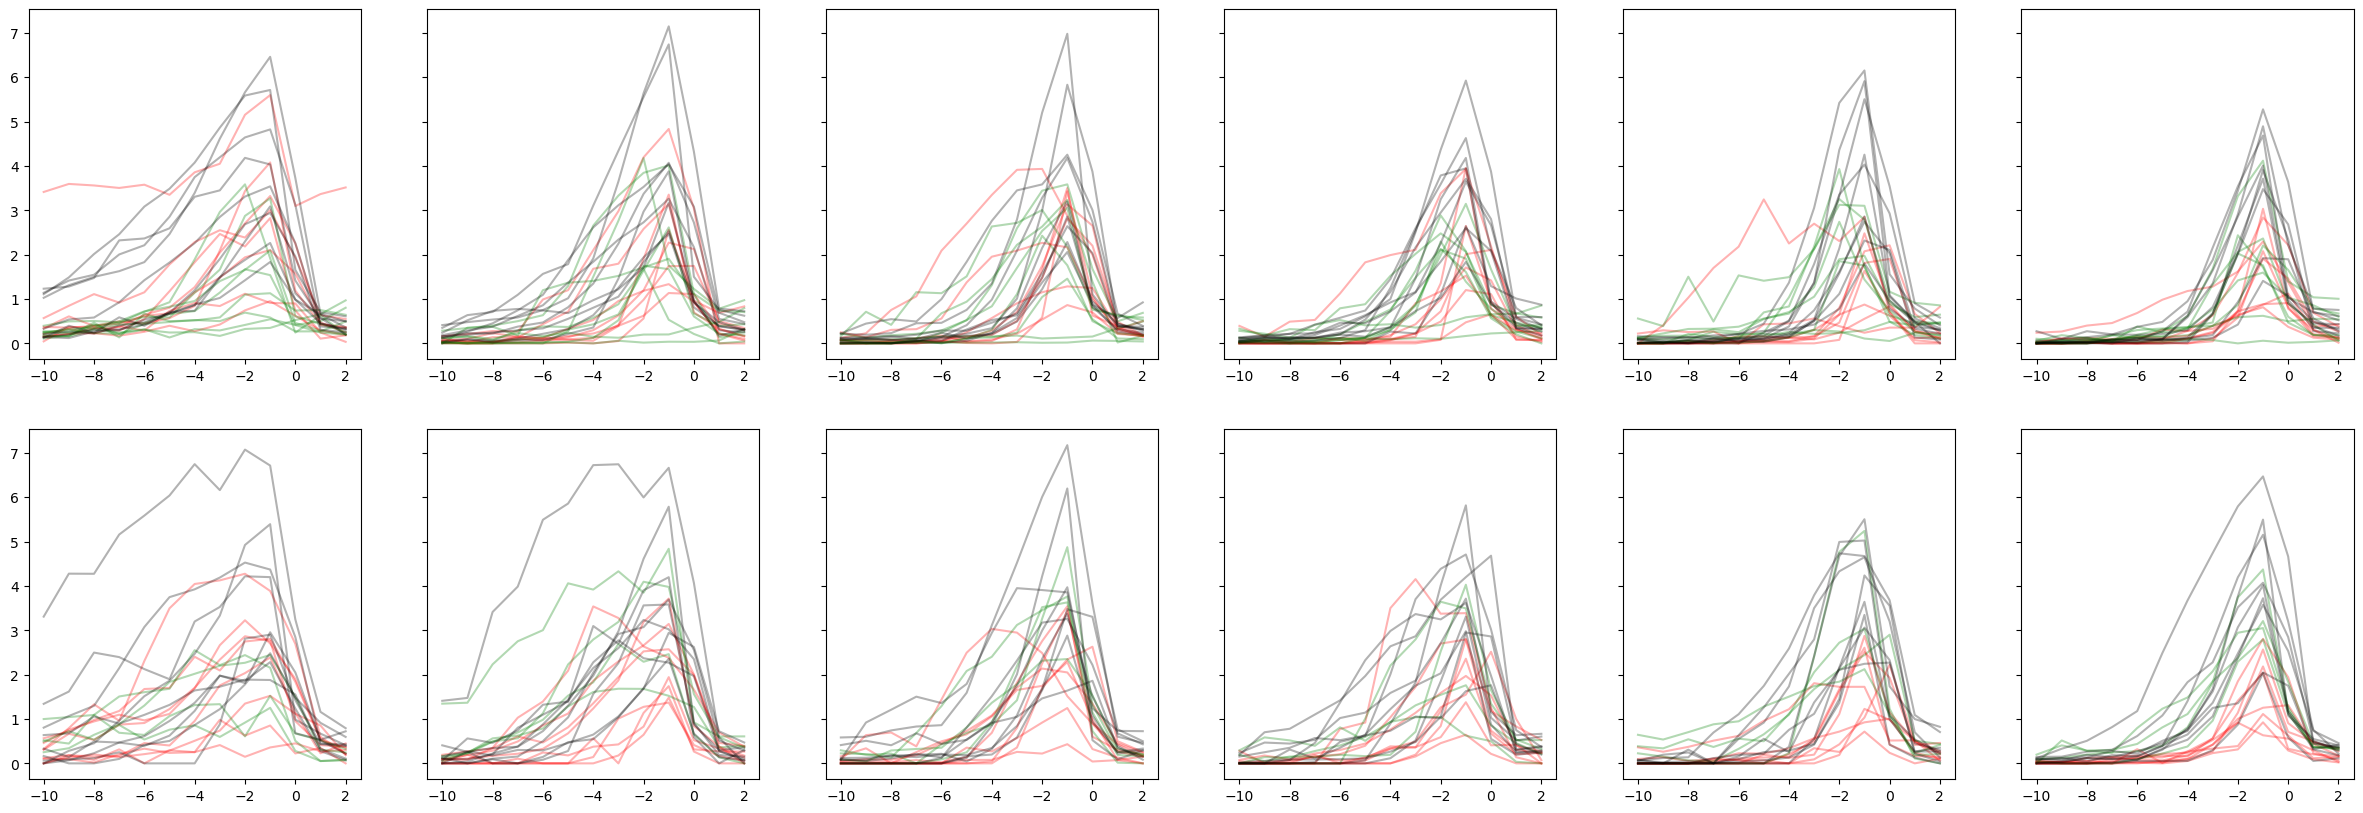

In [37]:

fig,ax = plt.subplots(2,6, figsize = [30, 10],sharey=True)


df_lick = pd.DataFrame({'mouse':[],
                        'cohort':[],
                        'day':[],
                        'day_norm': [],
                        'dz': [],
                        'ko_x_day': [],
                        'nov':[],
                        'ko_x_nov': [],
                        'lr': [],
                        'lickrate':[], 
                        'intercept': [],
                        })

key = 'nonconsum_licks'
if key in ('licks', 'nonconsum_licks'):
    alpha = dt
elif key in ('speed'):
    alpha = dt*10
else:
    alpha = 1.


ko_lr, ctrl_lr, sparse_lr = {}, {},{}
for day in range(6):
    ko_lr[day] = {'fam':[],'nov':[]}
    
    x = np.arange(-10,3)
    for mouse in ko_mice:

        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
            
#             lick_mean = np.nanmean(sess.trial_matrices['licks_sum'][trial_mask,:].ravel())

#             mu = dt*np.nanmean(sess.trial_matrices['nonconsum_licks'][trial_mask,:], axis=0)
            
            mu = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:], axis=0)

            if sess.novel_arm ==-1:
                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
            if lr == sess.novel_arm:
                ko_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ko_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front+1])
                ax[1,day].plot(x, mu[nov_rzone_front-10:nov_rzone_front+3],color='red', alpha = .3)
                df_lick = df_lick.append({'mouse': mouse, 
                                 'cohort': "KO", 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': (day+1)/6.,
                                 'nov': 1,
                                 'ko_x_nov': 1,
                                 'lr':ax_ind,
                                 'lickrate': _nov,
                                 'intercept': 1,
                                }, ignore_index=True)
            else:
                ko_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front+1])
                ax[0,day].plot(x, mu[fam_rzone_front-10:fam_rzone_front+3],color='red', alpha = .3)
                df_lick = df_lick.append({'mouse': mouse, 
                                 'cohort': "KO", 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': (day+1)/6.,
                                 'nov': 0,
                                 'ko_x_nov': 0,
                                 'lr': ax_ind,
                                 'lickrate': _fam,
                                 'intercept': 1,
                                }, ignore_index=True)
#                 ko_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                
                    
                
    sparse_lr[day] = {'fam':[],'nov':[]}
    
    x = np.arange(-10,3)
    for mouse in sparse_mice:

        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
            
#             lick_mean = np.nanmean(sess.trial_matrices['licks_sum'][trial_mask,:].ravel())

#             mu = dt*np.nanmean(sess.trial_matrices['nonconsum_licks'][trial_mask,:], axis=0)
            
            mu = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:], axis=0)

            if sess.novel_arm ==-1:
                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
            if lr == sess.novel_arm:
                ko_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ko_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front+1])
                ax[1,day].plot(x, mu[nov_rzone_front-10:nov_rzone_front+3],color='green', alpha = .3)
                df_lick = df_lick.append({'mouse': mouse, 
                                 'cohort': "Sparse", 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': (day+1)/6.,
                                 'nov': 1,
                                 'ko_x_nov': 0,
                                 'lr':ax_ind,
                                 'lickrate': _nov,
                                 'intercept': 1,
                                }, ignore_index=True)
            else:
                sparse_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front+1])
                ax[0,day].plot(x, mu[fam_rzone_front-10:fam_rzone_front+3],color='green', alpha = .3)
                df_lick = df_lick.append({'mouse': mouse, 
                                 'cohort': "Sparse", 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': (day+1)/6.,
                                 'nov': 0,
                                 'ko_x_nov': 0,
                                 'lr': ax_ind,
                                 'lickrate': _fam,
                                 'intercept': 1,
                                }, ignore_index=True)
#                 ko_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                   
                      

    ctrl_lr[day] = {'fam':[],'nov':[]}
    x = np.arange(-10,3)
    for mouse in ctrl_mice:
        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
#             lick_mean = np.nanmean(sess.trial_matrices['licks_sum'][trial_mask,:].ravel())

#             mu = dt*np.nanmean(sess.trial_matrices['nonconsum_licks'][trial_mask,:], axis=0)
            mu = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:], axis=0)

            if sess.novel_arm ==-1:

                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]

            if lr == sess.novel_arm:
                ctrl_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ctrl_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front+1])
                ax[1,day].plot(x, mu[nov_rzone_front-10:nov_rzone_front+3],color='black', alpha = .3)
                df_lick = df_lick.append({'mouse': mouse, 
                                 'cohort': "Control", 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': 0,
                                 'nov': 1,
                                 'ko_x_nov': 0,
                                 'lr': ax_ind,
                                 'lickrate': _nov,
                                 'intercept': 1,
                                }, ignore_index=True)
            else:
                ctrl_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
#                 ctrl_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front+1])
                ax[0,day].plot(x, mu[fam_rzone_front-10:fam_rzone_front+3],color='black', alpha = .3)
                
                df_lick = df_lick.append({'mouse': mouse, 
                                 'cohort': "Control", 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': 0,
                                 'nov': 0,
                                 'ko_x_nov': 0,
                                 'lr': ax_ind,
                                 'lickrate': _fam,
                                 'intercept': 1,
                                }, ignore_index=True)
        
    

# for day in range(6):
#     for ax_ind, lr in enumerate(['fam', 'nov']):
#         arr = np.array(ko_lr[day][lr])
#         mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
#         ax[ax_ind,day].fill_between(x, mu- sem, mu+sem,color='red', alpha = .3)

#         arr = np.array(ctrl_lr[day][lr])
#         mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
#         ax[ax_ind, day].fill_between(x, mu- sem, mu+sem,color='black', alpha = .3)
#     #     ax[ax_ind].plot(x, np.array(ko_mu[lr]).T,color='red', alpha = .3)


    
#         ax[ax_ind, day].fill_betweenx([0,5], 0, 2, zorder=-1, color='purple',alpha=.3)
#         ax[ax_ind, day].fill_betweenx([0,5], 0, 2, zorder=-1, color='purple',alpha=.3)

#         ax[ax_ind, day].set_xlabel('Position')
#         ax[ax_ind, day].set_xlabel('Position')
#         ax[ax_ind, day].set_ylabel('Lick Rate')
#         ax[ax_ind, day].spines['top'].set_visible(False)
#         ax[ax_ind, day].spines['top'].set_visible(False)
#         ax[ax_ind, day].spines['right'].set_visible(False)
#         ax[ax_ind, day].spines['right'].set_visible(False)

# fig.savefig(os.path.join(fig_dir, 'famnov_lickrate_alldays.pdf'))



In [14]:
df_lick

,mouse,cohort,day,day_norm,dz,ko_x_day,nov,ko_x_nov,lr,lickrate,intercept
0,4467975.1,KO,0.0,0.166667,NaN,0.166667,1.0,1.0,0.0,1.829353,1.0
1,4467975.1,KO,0.0,0.166667,NaN,0.166667,0.0,0.0,1.0,2.581329,1.0
2,4467975.2,KO,0.0,0.166667,NaN,0.166667,0.0,0.0,0.0,2.699191,1.0
3,4467975.2,KO,0.0,0.166667,NaN,0.166667,1.0,1.0,1.0,3.746024,1.0
4,4467975.3,KO,0.0,0.166667,NaN,0.166667,1.0,1.0,0.0,1.181917,1.0
...,...,...,...,...,...,...,...,...,...,...,...
235,mCherry7,Control,5.0,1.000000,NaN,0.000000,0.0,0.0,1.0,1.233476,1.0
236,mCherry8,Control,5.0,1.000000,NaN,0.000000,0.0,0.0,0.0,2.371933,1.0
237,mCherry8,Control,5.0,1.000000,NaN,0.000000,1.0,0.0,1.0,3.178919,1.0
238,mCherry9,Control,5.0,1.000000,NaN,0.000000,0.0,0.0,0.0,2.852792,1.0


In [17]:
lmm_results = smf.mixedlm('lickrate ~ 1 + C(cohort,Treatment("Control"))*day*lr', groups='mouse',
                          re_formula='~1',
                          data=df_lick,
                          missing='drop').fit(reml=True)
lmm_results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Mixed Linear Model Regression Results
===========================================================================================
Model:                        MixedLM             Dependent Variable:             lickrate 
No. Observations:             240                 Method:                         REML     
No. Groups:                   20                  Scale:                          0.3055   
Min. group size:              12                  Log-Likelihood:                 -239.3506
Max. group size:              12                  Converged:                      Yes      
Mean group size:              12.0                                                         
-------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                         2.516    0.278  9.052 0.000  1.971  3.061
C(cohort, Treatment("Control"))[T.KO]            -0.765    0.405 -1.887 0.059 -1.559  0.030
C(cohort, Treatment("Control"))[T.Sparse]        -0.610    0.556 -1.097 0.272 -1.700  0.480
day                                              -0.068    0.044 -1.549 0.121 -0.155  0.018
C(cohort, Treatment("Control"))[T.KO]:day        -0.128    0.064 -1.999 0.046 -0.254 -0.002
C(cohort, Treatment("Control"))[T.Sparse]:day     0.005    0.088  0.058 0.954 -0.168  0.178
lr                                                0.813    0.189  4.312 0.000  0.444  1.183
C(cohort, Treatment("Control"))[T.KO]:lr         -0.395    0.275 -1.438 0.150 -0.934  0.143
C(cohort, Treatment("Control"))[T.Sparse]:lr     -0.805    0.377 -2.135 0.033 -1.545 -0.066
day:lr                                           -0.061    0.062 -0.983 0.326 -0.183  0.061
C(cohort, Treatment("Control"))[T.KO]:day:lr      0.040    0.091  0.441 0.659 -0.138  0.218
C(cohort, Treatment("Control"))[T.Sparse]:day:lr  0.219    0.125  1.759 0.079 -0.025  0.463
mouse Var                                         0.535    0.362                           
===========================================================================================

"""

In [18]:
lmm_results = smf.mixedlm('lickrate ~ 1 + C(cohort,Treatment("KO"))*day*lr', groups='mouse',
                          re_formula='~1',
                          data=df_lick,
                          missing='drop').fit(reml=True)
lmm_results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
=======================================================================================
Model:                        MixedLM           Dependent Variable:           lickrate 
No. Observations:             240               Method:                       REML     
No. Groups:                   20                Scale:                        0.3055   
Min. group size:              12                Log-Likelihood:               -239.3506
Max. group size:              12                Converged:                    Yes      
Mean group size:              12.0                                                     
---------------------------------------------------------------------------------------
                                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                     1.751    0.295  5.941 0.000  1.174  2.329
C(cohort, Treatment("KO"))[T.Control]         0.765    0.405  1.887 0.059 -0.030  1.559
C(cohort, Treatment("KO"))[T.Sparse]          0.155    0.565  0.274 0.784 -0.952  1.261
day                                          -0.197    0.047 -4.207 0.000 -0.288 -0.105
C(cohort, Treatment("KO"))[T.Control]:day     0.128    0.064  1.999 0.046  0.002  0.254
C(cohort, Treatment("KO"))[T.Sparse]:day      0.133    0.089  1.492 0.136 -0.042  0.309
lr                                            0.418    0.200  2.089 0.037  0.026  0.810
C(cohort, Treatment("KO"))[T.Control]:lr      0.395    0.275  1.438 0.150 -0.143  0.934
C(cohort, Treatment("KO"))[T.Sparse]:lr      -0.410    0.383 -1.070 0.284 -1.161  0.341
day:lr                                       -0.021    0.066 -0.321 0.748 -0.151  0.108
C(cohort, Treatment("KO"))[T.Control]:day:lr -0.040    0.091 -0.441 0.659 -0.218  0.138
C(cohort, Treatment("KO"))[T.Sparse]:day:lr   0.179    0.127  1.416 0.157 -0.069  0.427
mouse Var                                     0.535    0.362                           
=======================================================================================

"""

<Axes: xlabel='day', ylabel='lickrate'>

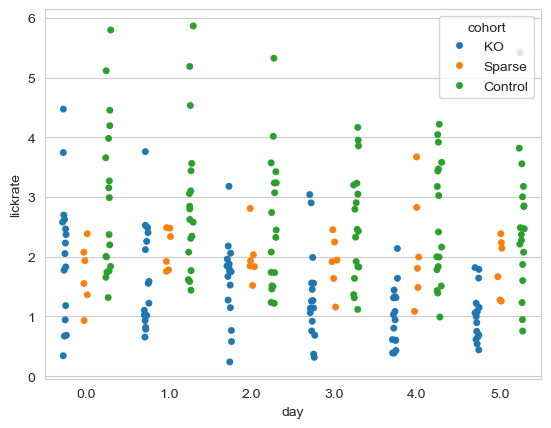

In [57]:
sns.stripplot(data=df_lick, x='day', y='lickrate', hue='cohort', dodge=True)


In [54]:
sparse_mice

('SparseKO_06',
 'SparseKO_08',
 'SparseKO_09',
 'SparseKO_10',
 'SparseKO_11',
 'SparseKO_13')

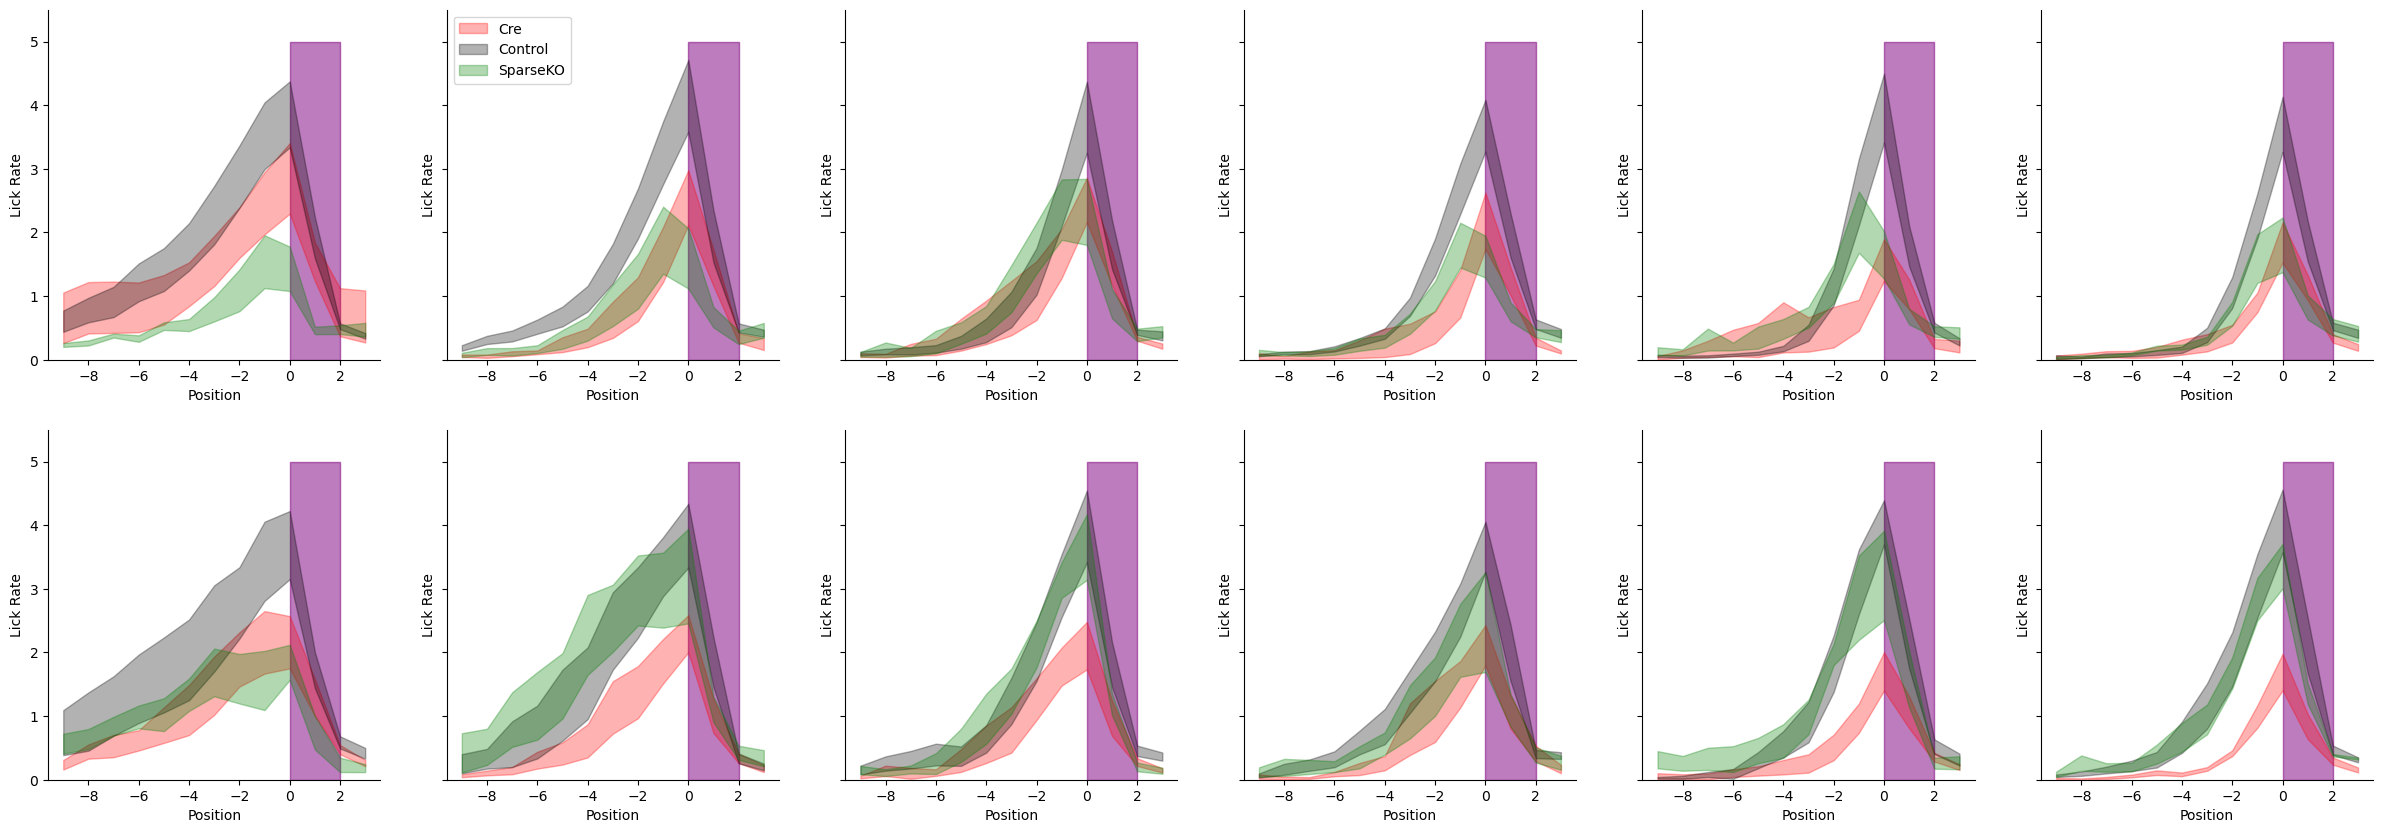

In [55]:
fig,ax = plt.subplots(2,6, figsize = [30, 10],sharey=True)


df = {'mouse':[],
      'ko':[],
      'day':[],
      'nov':[],
      'lickrate': [],
      }

key = 'nonconsum_licks'
if key in ('licks', 'nonconsum_licks'):
    alpha = dt
elif key in ('speed'):
    alpha = dt*10
else:
    alpha = 1.
ko_lr, ctrl_lr, sparse_lr = {}, {}, {}
for day in range(6):
    ko_lr[day] = {'fam':[],'nov':[]}
    
    x = np.arange(-10,3)
    for mouse in ko_mice:

        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
#             lick_mean = np.nanmean(sess.trial_matrices['licks_sum'][trial_mask,:].ravel())

#             mu = dt*np.nanmean(sess.trial_matrices['nonconsum_licks'][trial_mask,:], axis=0)
            
            mu = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:], axis=0)

            if sess.novel_arm ==-1:
                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
            if lr == sess.novel_arm:
                ko_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ko_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front+1])
                df['mouse'].append(mouse)
                df['ko'].append('ko')
                df['day'].append(day)
                df['nov'].append('nov')
                df['lickrate'].append(_nov)

            else:
                ko_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front+1])
                df['mouse'].append(mouse)
                df['ko'].append('ko')
                df['day'].append(day)
                df['nov'].append('fam')
                df['lickrate'].append(_fam)

    ctrl_lr[day] = {'fam':[],'nov':[]}
    x = np.arange(-9,4)
    for mouse in ctrl_mice:
        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
#             lick_mean = np.nanmean(sess.trial_matrices['licks_sum'][trial_mask,:].ravel())

#             mu = dt*np.nanmean(sess.trial_matrices['nonconsum_licks'][trial_mask,:], axis=0)
            mu = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:], axis=0)

            if sess.novel_arm ==-1:

                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]

            if lr == sess.novel_arm:
                ctrl_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ctrl_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front+1])
                df['mouse'].append(mouse)
                df['ko'].append('ctrl')
                df['day'].append(day)
                df['nov'].append('nov')
                df['lickrate'].append(_nov)

            else:
                ctrl_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
#                 ctrl_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front+1])
                df['mouse'].append(mouse)
                df['ko'].append('ctrl')
                df['day'].append(day)
                df['nov'].append('fam')
                df['lickrate'].append(_fam)
    sparse_lr[day] = {'fam':[],'nov':[]}
    x = np.arange(-9,4)
    for mouse in sparse_mice:
        if day == 2 and mouse =="SparseKO_09":
            continue
        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
#             lick_mean = np.nanmean(sess.trial_matrices['licks_sum'][trial_mask,:].ravel())

#             mu = dt*np.nanmean(sess.trial_matrices['nonconsum_licks'][trial_mask,:], axis=0)
            mu = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:], axis=0)

            if sess.novel_arm ==-1:

                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]

            if lr == sess.novel_arm:
                sparse_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ctrl_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front+1])
                df['mouse'].append(mouse)
                df['ko'].append('sparse')
                df['day'].append(day)
                df['nov'].append('nov')
                df['lickrate'].append(_nov)

            else:
                sparse_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
#                 ctrl_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front+1])
                df['mouse'].append(mouse)
                df['ko'].append('sparse')
                df['day'].append(day)
                df['nov'].append('fam')
                df['lickrate'].append(_fam)

            
df = pd.DataFrame(df)
        
    

for day in range(6):
    for ax_ind, lr in enumerate(['fam', 'nov']):
        arr = np.array(ko_lr[day][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind,day].fill_between(x, mu- sem, mu+sem,color='red', alpha = .3, label='Cre')

        arr = np.array(ctrl_lr[day][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind, day].fill_between(x, mu- sem, mu+sem,color='black', alpha = .3, label='Control')

        arr = np.array(sparse_lr[day][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind, day].fill_between(x, mu- sem, mu+sem,color='green', alpha = .3, label='SparseKO')
    #     ax[ax_ind].plot(x, np.array(ko_mu[lr]).T,color='red', alpha = .3)


    
        ax[ax_ind, day].fill_betweenx([0,5], 0, 2, zorder=-1, color='purple',alpha=.3)
        ax[ax_ind, day].fill_betweenx([0,5], 0, 2, zorder=-1, color='purple',alpha=.3)

        ax[ax_ind, day].set_xlabel('Position')
        ax[ax_ind, day].set_xlabel('Position')
        ax[ax_ind, day].set_ylabel('Lick Rate')
        ax[ax_ind, day].spines['top'].set_visible(False)
        ax[ax_ind, day].spines['top'].set_visible(False)
        ax[ax_ind, day].spines['right'].set_visible(False)
        ax[ax_ind, day].spines['right'].set_visible(False)
        ax[ax_ind, day].set_ylim([0,5.5])
ax[0,1].legend(loc = 'upper left')

fig.savefig(os.path.join(fig_dir, 'famnov_lickrate_alldays.pdf'))

In [16]:
aov = mixed_anova(data=df[df['nov']=='nov'], dv='lickrate', between='ko', within='day', subject='mouse')
print(aov)
print(aov['p-unc'].iloc[1])

posthoc = pairwise_ttests(data=df[df['nov']=='nov'], dv='lickrate', between='ko', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

        Source         SS  DF1  DF2         MS         F     p-unc       np2  \
0           ko  42.832149    1   15  42.832149  8.402531  0.011023  0.359044   
1          day   3.424709    5   75   0.684942  2.011024  0.086710  0.118219   
2  Interaction   2.254700    5   75   0.450940  1.323982  0.263227  0.081107   

       eps  
0      NaN  
1  0.70181  
2      NaN  
0.08670957015921336
    Contrast day     A   B Paired  Parametric         T        dof  \
0        day   -     0   1   True        True  0.133476  16.000000   
1        day   -     0   2   True        True  1.009938  16.000000   
2        day   -     0   3   True        True  1.420135  16.000000   
3        day   -     0   4   True        True  1.663410  16.000000   
4        day   -     0   5   True        True  2.199804  16.000000   
5        day   -     1   2   True        True  1.337315  16.000000   
6        day   -     1   3   True        True  1.619456  16.000000   
7        day   -     1   4   True        True  

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"

In [17]:
aov = mixed_anova(data=df[df['nov']=='fam'], dv='lickrate', between='ko', within='day', subject='mouse')
print(aov)
print(aov['p-unc'].iloc[1])

posthoc = pairwise_ttests(data=df[df['nov']=='fam'], dv='lickrate', between='ko', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

        Source         SS  DF1  DF2         MS          F     p-unc       np2  \
0           ko  37.903867    1   15  37.903867  10.663782  0.005215  0.415519   
1          day   9.413276    5   75   1.882655   7.556441  0.000009  0.335001   
2  Interaction   0.997572    5   75   0.199514   0.800794  0.552612  0.050681   

        eps  
0       NaN  
1  0.688216  
2       NaN  
8.614145765397674e-06
    Contrast day     A   B Paired  Parametric         T        dof  \
0        day   -     0   1   True        True  1.398939  16.000000   
1        day   -     0   2   True        True  2.754402  16.000000   
2        day   -     0   3   True        True  3.180116  16.000000   
3        day   -     0   4   True        True  4.929344  16.000000   
4        day   -     0   5   True        True  4.374278  16.000000   
5        day   -     1   2   True        True  1.984348  16.000000   
6        day   -     1   3   True        True  3.010909  16.000000   
7        day   -     1   4   True    

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"

In [54]:
sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
sess.trial_matrices['speed']

array([[0.07213459, 0.06848823, 0.09079879, ..., 0.07953301, 0.11597024,
        0.173123  ],
       [0.03817585, 0.0771712 , 0.1312691 , ..., 0.093664  , 0.11985439,
        0.1198544 ],
       [0.04712224, 0.07916308, 0.13317155, ..., 0.09120233, 0.12683007,
        0.17756205],
       ...,
       [0.05407572, 0.11652509, 0.15219609, ..., 0.08468346, 0.093664  ,
        0.09322009],
       [0.074909  , 0.1426838 , 0.18111332, ..., 0.10254208, 0.10703048,
        0.10875675],
       [0.05326862, 0.11689504, 0.13697649, ..., 0.12706784, 0.09943475,
        0.1043177 ]])

In [70]:
sess.trial_matrices.keys()

dict_keys(['speed_raw', 'bin_edges', 'bin_centers', 'speed', 'licks_rate', 'licks', 'nonconsum_licks', 'licks_sum'])

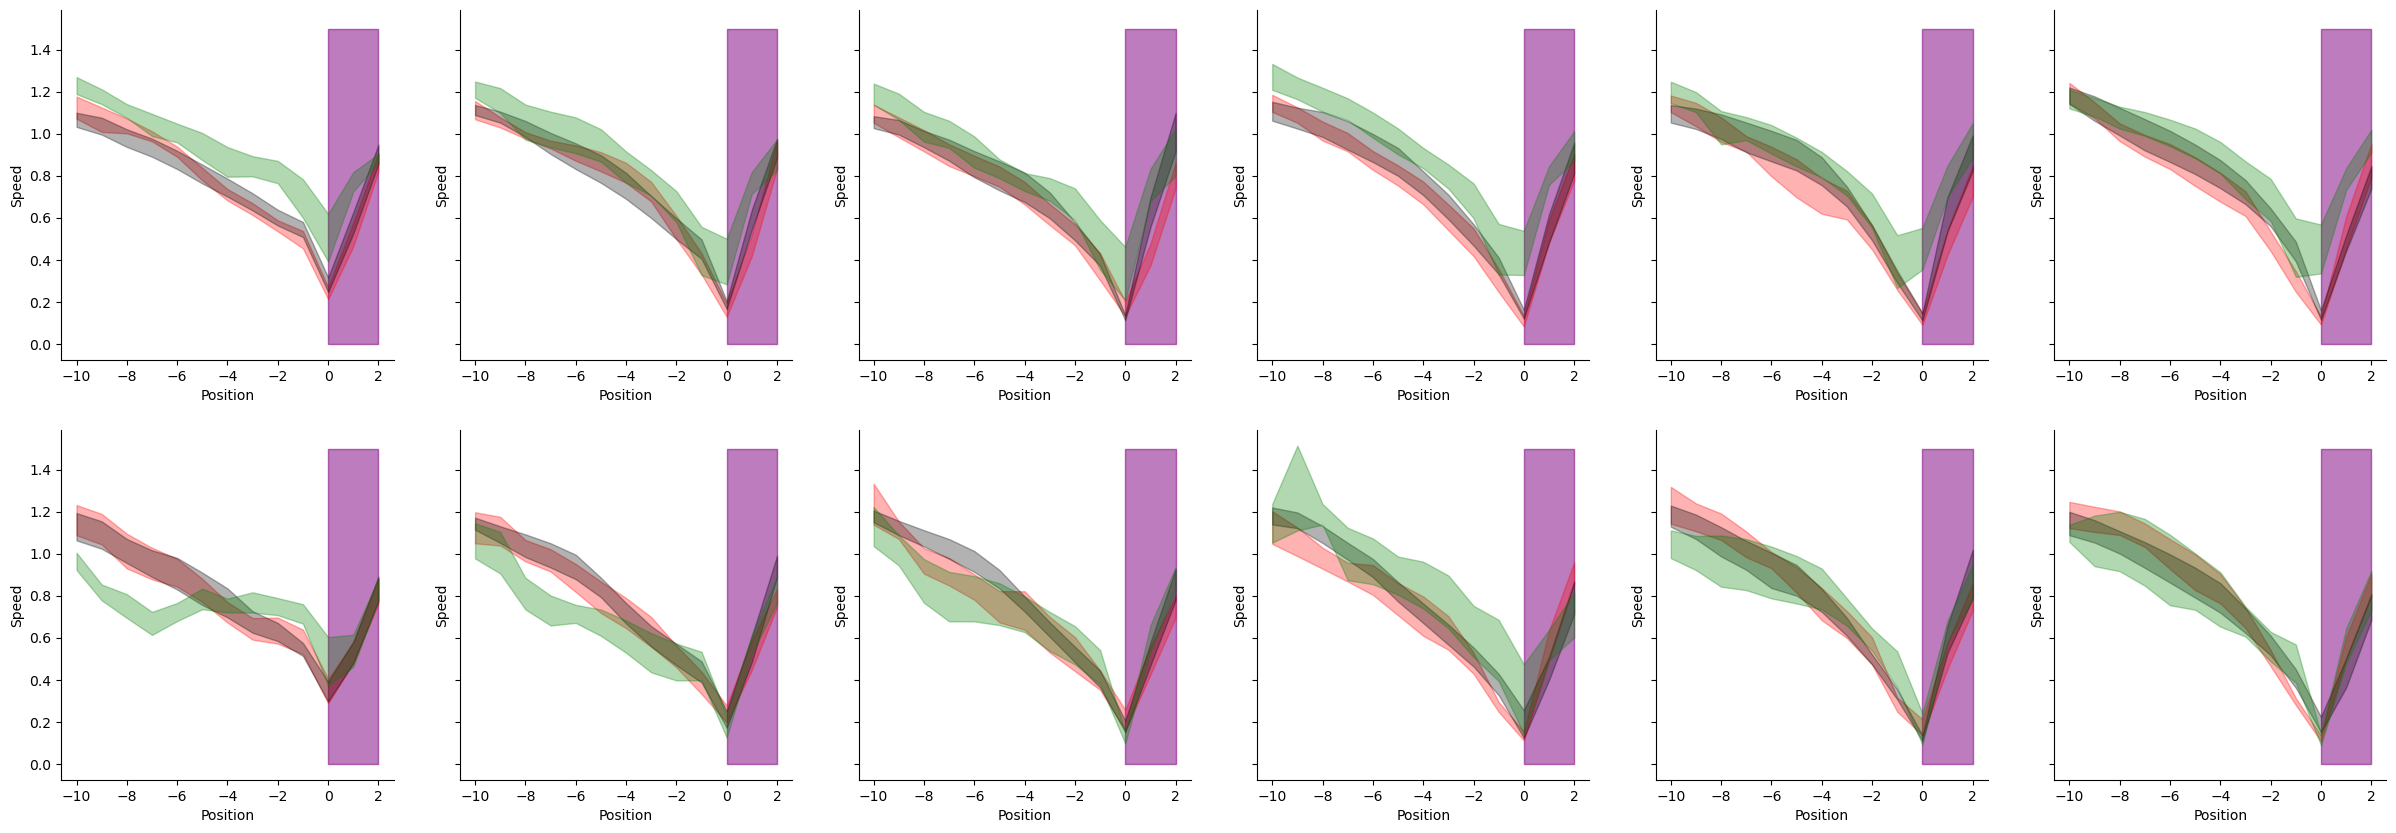

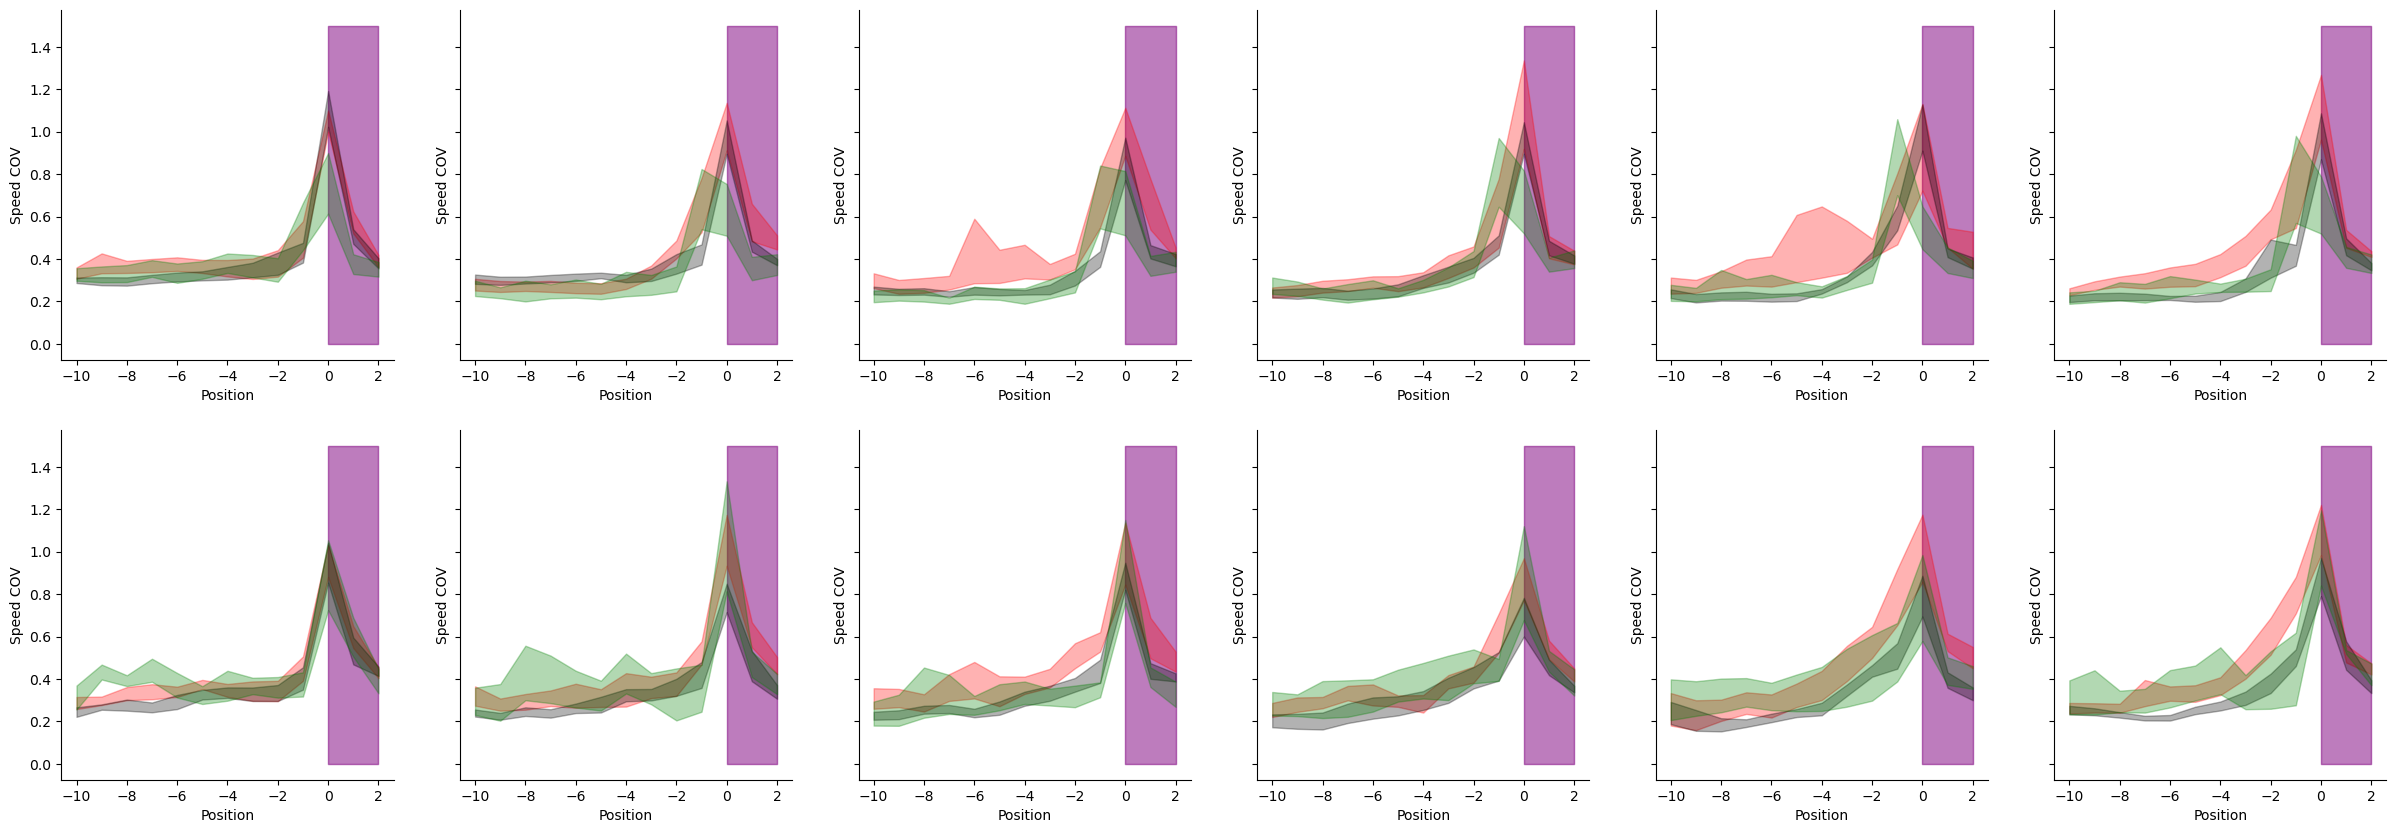

In [88]:
df_speed = {'mouse':[],
      'cohort':[],
      'day':[],
      'nov':[],
      'speed':[],
      'cov': [],
      'lr':[]     }

key = 'speed'
if key in ('licks', 'nonconsum_licks'):
    alpha = dt
elif key in ('speed'):
    alpha = dt*10
else:
    alpha = 1.
ko_lr, ctrl_lr, sparse_lr = {}, {}, {}
for day in range(6):
    ko_lr[day] = {'speed':{'fam':[],'nov':[]}, 'cov':{'fam':[], 'nov':[]}}
    
    x = np.arange(-10,3)
    for mouse in ko_mice:

        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
            
            grand_mean = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:].ravel())
            std = np.nanstd(alpha*sess.trial_matrices[key][trial_mask,:]/grand_mean, axis=0)
            mu = np.nanmean(alpha*sess.trial_matrices[key][trial_mask,:]/grand_mean, axis=0) #/grandmean
            cov = std/mu
            # mu = 

            if sess.novel_arm ==-1:
                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
            if lr == sess.novel_arm:
                ko_lr[day]['cov']['nov'].append(cov[nov_rzone_front-10:nov_rzone_front+3])
                ko_lr[day]['speed']['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
                # ko_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                
                _mu = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front])
                _cov = np.nanmean(cov[nov_rzone_front-3:nov_rzone_front])
                df_speed['mouse'].append(mouse)
                df_speed['cohort'].append("KO")
                df_speed['day'].append(day)
                df_speed['nov'].append(True)
                df_speed['speed'].append(_mu)
                df_speed['cov'].append(_cov)
                df_speed['lr'].append(lr)
                
            else:
                ko_lr[day]['cov']['fam'].append(cov[fam_rzone_front-10:fam_rzone_front+3])
                ko_lr[day]['speed']['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
                # _fam = np.nanmean(mu[fam_rzone_front-10:fam_rzone_front-1])
                
                _mu = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front])
                _cov = np.nanmean(cov[fam_rzone_front-3:fam_rzone_front])
                df_speed['mouse'].append(mouse)
                df_speed['cohort'].append("KO")
                df_speed['day'].append(day)
                df_speed['nov'].append(False)
                df_speed['speed'].append(_mu)
                df_speed['cov'].append(_cov)
                df_speed['lr'].append(lr)
                
                # ko_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                
                    
                
       
                      

    ctrl_lr[day] = {'speed':{'fam':[],'nov':[]}, 'cov':{'fam':[], 'nov':[]}}
    x = np.arange(-10,3)
    for mouse in ctrl_mice:
        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
#             lick_mean = np.nanmean(sess.trial_matrices['licks_sum'][trial_mask,:].ravel())

#             mu = dt*np.nanmean(sess.trial_matrices['nonconsum_licks'][trial_mask,:], axis=0)
            grand_mean = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:].ravel())
            std = np.nanstd(alpha*sess.trial_matrices[key][trial_mask,:]/grand_mean, axis=0)
            mu = np.nanmean(alpha*sess.trial_matrices[key][trial_mask,:]/grand_mean, axis=0) #/grandmean
            cov = std/mu

            if sess.novel_arm ==-1:

                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]

            if lr == sess.novel_arm:
                ctrl_lr[day]['cov']['nov'].append(cov[nov_rzone_front-10:nov_rzone_front+3])
                ctrl_lr[day]['speed']['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])

                

                _mu = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front])
                _cov = np.nanmean(cov[nov_rzone_front-3:nov_rzone_front])
                df_speed['mouse'].append(mouse)
                df_speed['cohort'].append("control")
                df_speed['day'].append(day)
                df_speed['nov'].append(True)
                df_speed['speed'].append(_mu)
                df_speed['cov'].append(_cov)
                df_speed['lr'].append(lr)
                
            else:
                ctrl_lr[day]['cov']['fam'].append(cov[fam_rzone_front-10:fam_rzone_front+3])
                ctrl_lr[day]['speed']['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])

                _mu = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front])
                _cov = np.nanmean(cov[fam_rzone_front-3:fam_rzone_front])
                df_speed['mouse'].append(mouse)
                df_speed['cohort'].append("control")
                df_speed['day'].append(day)
                df_speed['nov'].append(False)
                df_speed['speed'].append(_mu)
                df_speed['cov'].append(_cov)
                df_speed['lr'].append(lr)

    sparse_lr[day] = {'speed':{'fam':[],'nov':[]}, 'cov':{'fam':[], 'nov':[]}}
    
    x = np.arange(-10,3)
    for mouse in sparse_mice:
        if mouse == 'SparseKO_09' and day ==2:
            continue
        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
            
            grand_mean = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:].ravel())
            std = np.nanstd(alpha*sess.trial_matrices[key][trial_mask,:]/grand_mean, axis=0)
            mu = np.nanmean(alpha*sess.trial_matrices[key][trial_mask,:]/grand_mean, axis=0) #/grandmean
            cov = std/mu
            # mu = 

            if sess.novel_arm ==-1:
                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
            if lr == sess.novel_arm:
                sparse_lr[day]['cov']['nov'].append(cov[nov_rzone_front-10:nov_rzone_front+3])
                sparse_lr[day]['speed']['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
                # ko_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                
                _mu = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front])
                _cov = np.nanmean(cov[nov_rzone_front-3:nov_rzone_front])
                df_speed['mouse'].append(mouse)
                df_speed['cohort'].append("sparse")
                df_speed['day'].append(day)
                df_speed['nov'].append(True)
                df_speed['speed'].append(_mu)
                df_speed['cov'].append(_cov)
                df_speed['lr'].append(lr)
                
            else:
                sparse_lr[day]['cov']['fam'].append(cov[fam_rzone_front-10:fam_rzone_front+3])
                sparse_lr[day]['speed']['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
                # _fam = np.nanmean(mu[fam_rzone_front-10:fam_rzone_front-1])
                
                _mu = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front])
                _cov = np.nanmean(cov[fam_rzone_front-3:fam_rzone_front])
                df_speed['mouse'].append(mouse)
                df_speed['cohort'].append("sparse")
                df_speed['day'].append(day)
                df_speed['nov'].append(False)
                df_speed['speed'].append(_mu)
                df_speed['cov'].append(_cov)
                df_speed['lr'].append(lr)
                
                # ko_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
    
df_speed = pd.DataFrame(df_speed)

# normalized speed
fig,ax = plt.subplots(2,6, figsize = [30, 10],sharey=True)
for day in range(6):
    for ax_ind, lr in enumerate(['fam', 'nov']):
        arr = np.array(ko_lr[day]['speed'][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind,day].fill_between(x, mu- sem, mu+sem,color='red', alpha = .3)

        arr = np.array(ctrl_lr[day]['speed'][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind, day].fill_between(x, mu- sem, mu+sem,color='black', alpha = .3)

        arr = np.array(sparse_lr[day]['speed'][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind, day].fill_between(x, mu- sem, mu+sem,color='green', alpha = .3)


    
        ax[ax_ind, day].fill_betweenx([0,1.5], 0, 2, zorder=-1, color='purple',alpha=.3)
        ax[ax_ind, day].fill_betweenx([0,1.5], 0, 2, zorder=-1, color='purple',alpha=.3)

        ax[ax_ind, day].set_xlabel('Position')
        ax[ax_ind, day].set_xlabel('Position')
        ax[ax_ind, day].set_ylabel('Speed')
        ax[ax_ind, day].spines['top'].set_visible(False)
        ax[ax_ind, day].spines['top'].set_visible(False)
        ax[ax_ind, day].spines['right'].set_visible(False)
        ax[ax_ind, day].spines['right'].set_visible(False)
        
fig.savefig(os.path.join(fig_dir, 'famnov_speed_alldays.pdf'))     
        
fig,ax = plt.subplots(2,6, figsize = [30, 10],sharey=True)
for day in range(6):
    for ax_ind, lr in enumerate(['fam', 'nov']):
        arr = np.array(ko_lr[day]['cov'][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind,day].fill_between(x, mu- sem, mu+sem,color='red', alpha = .3)

        arr = np.array(ctrl_lr[day]['cov'][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind, day].fill_between(x, mu- sem, mu+sem,color='black', alpha = .3)
   
        arr = np.array(sparse_lr[day]['cov'][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind, day].fill_between(x, mu- sem, mu+sem,color='green', alpha = .3)

    
        ax[ax_ind, day].fill_betweenx([0,1.5], 0, 2, zorder=-1, color='purple',alpha=.3)
        ax[ax_ind, day].fill_betweenx([0,1.5], 0, 2, zorder=-1, color='purple',alpha=.3)

        ax[ax_ind, day].set_xlabel('Position')
        ax[ax_ind, day].set_xlabel('Position')
        ax[ax_ind, day].set_ylabel('Speed COV')
        ax[ax_ind, day].spines['top'].set_visible(False)
        ax[ax_ind, day].spines['top'].set_visible(False)
        ax[ax_ind, day].spines['right'].set_visible(False)
        ax[ax_ind, day].spines['right'].set_visible(False)

        


fig.savefig(os.path.join(fig_dir, 'famnov_speedCOV_alldays.pdf'))

In [89]:
df_speed

,mouse,cohort,day,nov,speed,cov,lr
0,4467975.1,KO,0,True,0.593030,0.348665,-1
1,4467975.1,KO,0,False,0.500654,0.370965,1
2,4467975.2,KO,0,False,0.458188,0.396358,-1
3,4467975.2,KO,0,True,0.410647,0.317303,1
4,4467975.3,KO,0,True,0.668222,0.217346,-1
...,...,...,...,...,...,...,...
269,SparseKO_10,sparse,5,True,0.434676,0.772894,1
270,SparseKO_11,sparse,5,False,0.376015,0.460092,-1
271,SparseKO_11,sparse,5,True,0.500623,0.272094,1
272,SparseKO_13,sparse,5,False,0.739996,0.322537,-1


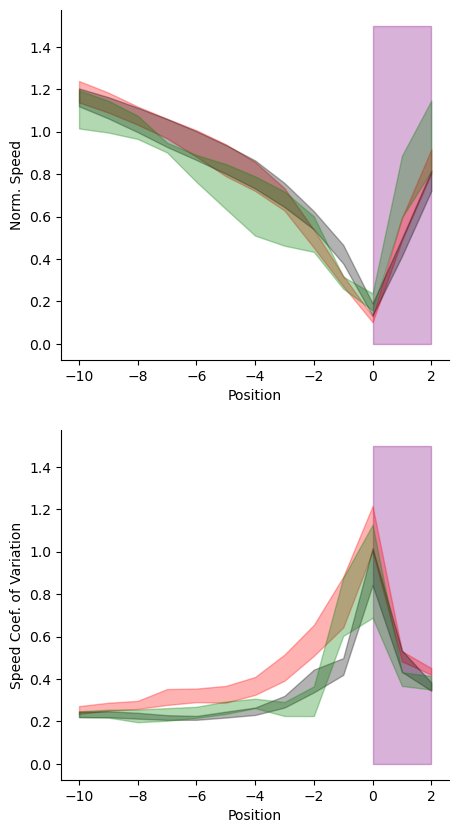

In [58]:
fig,ax = plt.subplots(2,1, figsize = [5, 10],sharey=True)
day = 5
x = np.arange(-10,3)


arr = np.concatenate((np.array(ko_lr[day]['speed']['fam'])[:,:,np.newaxis], np.array(ko_lr[day]['speed']['nov'])[:, :, np.newaxis]), axis=-1)
arr = arr.mean(axis=-1)
mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')

ax[0].fill_between(x, mu- sem, mu+sem,color='red', alpha = .3)

arr = np.concatenate((np.array(ctrl_lr[day]['speed']['fam'])[:,:,np.newaxis], np.array(ctrl_lr[day]['speed']['nov'])[:, :, np.newaxis]), axis=-1)
arr = arr.mean(axis=-1)
mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')

ax[0].fill_between(x, mu- sem, mu+sem,color='black', alpha = .3)

arr = np.concatenate((np.array(sparse_lr[day]['speed']['fam'])[:,:,np.newaxis], np.array(sparse_lr[day]['speed']['nov'])[:, :, np.newaxis]), axis=-1)
arr = arr.mean(axis=-1)
mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')

ax[0].fill_between(x, mu- sem, mu+sem,color='green', alpha = .3)


ax[0].fill_betweenx([0,1.5], 0, 2, zorder=-1, color='purple',alpha=.3)

ax[0].set_ylabel('Norm. Speed')
ax[0].set_xlabel('Position')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)


arr = np.concatenate((np.array(ko_lr[day]['cov']['fam'])[:,:,np.newaxis], np.array(ko_lr[day]['cov']['nov'])[:, :, np.newaxis]), axis=-1)
arr = arr.mean(axis=-1)
mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')

ax[1].fill_between(x, mu- sem, mu+sem,color='red', alpha = .3)

arr = np.concatenate((np.array(ctrl_lr[day]['cov']['fam'])[:,:,np.newaxis], np.array(ctrl_lr[day]['cov']['nov'])[:, :, np.newaxis]), axis=-1)
arr = arr.mean(axis=-1)
mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')

ax[1].fill_between(x, mu- sem, mu+sem,color='black', alpha = .3)

arr = np.concatenate((np.array(sparse_lr[day]['cov']['fam'])[:,:,np.newaxis], np.array(sparse_lr[day]['cov']['nov'])[:, :, np.newaxis]), axis=-1)
arr = arr.mean(axis=-1)
mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')

ax[1].fill_between(x, mu- sem, mu+sem,color='green', alpha = .3)

ax[1].fill_betweenx([0,1.5], 0, 2, zorder=-1, color='purple',alpha=.3)

ax[1].set_ylabel('Speed Coef. of Variation')
ax[1].set_xlabel('Position')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

fig.savefig(os.path.join(fig_dir, 'day6_normspeed_COV.pdf'))

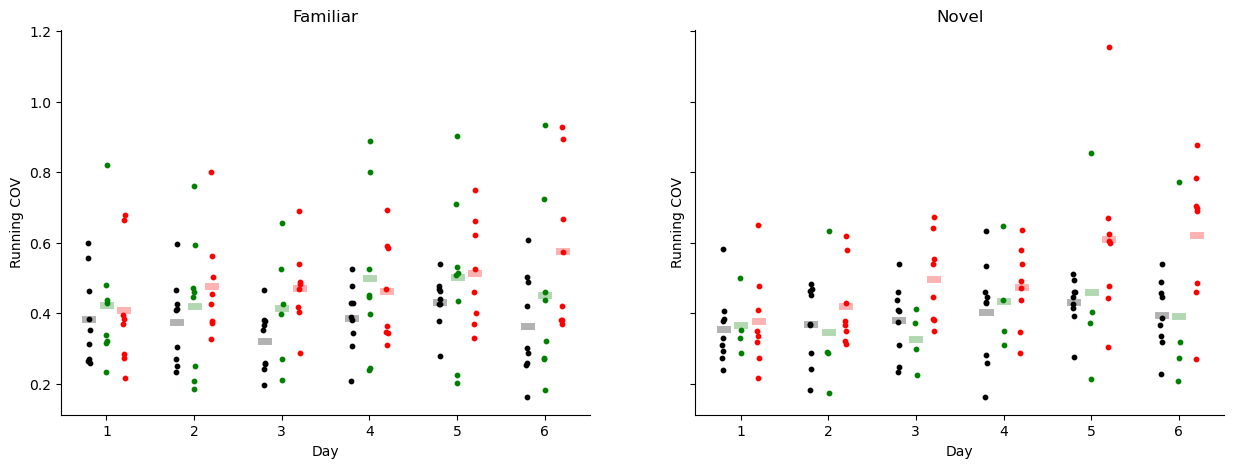

In [79]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

lw = 5
s = 10
key = 'cov'
for day in range(6):
    
    mask = (df['cohort']=="control") & (df['day']==day) & (df['nov']==False)
    lr = df[key].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cohort']=="control") & (df['day']==day) & (df['nov']==True)
    lr = df[key].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cohort']=="KO") & (df['day']==day) & (df['nov']==False)
    lr = df[key].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cohort']=="KO") & (df['day']==day)& (df['nov']==True)
    lr = df[key].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)

    mask = (df['cohort']=="sparse") & (df['day']==day) & (df['nov']==False)
    lr = df[key].loc[mask]._values
    ax[0].scatter(5*day  + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='green', s=s)
    ax[0].plot(5*day  + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='green', linewidth=lw,alpha = .3)
    
    mask = (df['cohort']=="sparse") & (df['day']==day) & (df['nov']==True)
    lr = df[key].loc[mask]._values
    ax[1].scatter(5*day + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='green', s=s, alpha = 1)
    ax[1].plot(5*day + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='green', linewidth=lw,alpha = .3)
    
ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Running COV')
    ax[a].set_xlabel('Day')

fig.savefig(os.path.join(fig_dir, 'famnov_speed_COV_summary.pdf'))

In [91]:
df = df_speed

### Key for L/R 
* LR = 1 LEFT / blue / late reward
* LR = -1 RIGHT / green / early reward

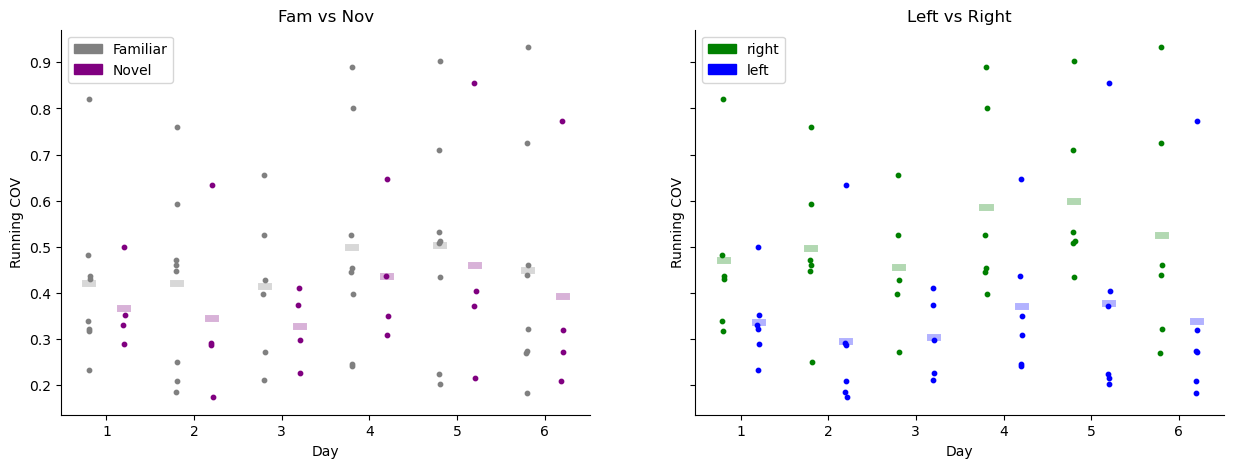

In [104]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

lw = 5
s = 10
key = 'cov'
for day in range(6):

    # fam vs nov
    mask = (df['cohort']=="sparse") & (df['day']==day) & (df['nov']==False)
    lr = df[key].loc[mask]._values
    ax[0].scatter(5*day-1  + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='grey', s=s)
    ax[0].plot(5*day-1  + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='grey', linewidth=lw,alpha = .3)
    
    mask = (df['cohort']=="sparse") & (df['day']==day) & (df['nov']==True)
    lr = df[key].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='purple', s=s, alpha = 1)
    ax[0].plot(5*day+1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='purple', linewidth=lw,alpha = .3)


    # left vs right
    
    mask = (df['cohort']=="sparse") & (df['day']==day) & (df['lr']==-1)
    lr = df[key].loc[mask]._values
    ax[1].scatter(5*day-1  + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='green', s=s)
    ax[1].plot(5*day-1  + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='green', linewidth=lw,alpha = .3)
    
    mask = (df['cohort']=="sparse") & (df['day']==day) & (df['lr']==1)
    lr = df[key].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='blue', s=s, alpha = 1)
    ax[1].plot(5*day+1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='blue', linewidth=lw,alpha = .3)
    
ax[0].set_title('Fam vs Nov')
ax[1].set_title('Left vs Right')



for a in range(2):
    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])
    
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    
    ax[a].set_ylabel('Running COV')
    ax[a].set_xlabel('Day')

familiar_patch = mpatches.Patch(color='grey',label='Familiar')
novel_patch = mpatches.Patch(color='purple',label='Novel')
ax[0].legend(
    handles=[familiar_patch, novel_patch]
)
right_patch = mpatches.Patch(color='green',label='right')
left_patch = mpatches.Patch(color='blue',label='left')
ax[1].legend(
    handles=[right_patch, left_patch]
)


In [61]:

aov = mixed_anova(data=df[df['nov']==False], dv='cov', between='ko', within='day', subject='mouse')
print(aov)
print(aov['p-unc'].iloc[1])

posthoc = pairwise_ttests(data=df[df['nov']==False], dv='cov', between='ko', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

        Source        SS  DF1  DF2        MS         F     p-unc  p-GG-corr  \
0           ko  0.395668    1   15  0.395668  9.988894  0.006466        NaN   
1          day  0.126715    5   75  0.025343  1.327126  0.261961   0.274127   
2  Interaction  0.081413    5   75  0.016283  0.852667  0.517011        NaN   

        np2       eps sphericity  W-spher   p-spher  
0  0.399733       NaN        NaN      NaN       NaN  
1  0.081284  0.549124      False  0.08233  0.001555  
2  0.053787       NaN        NaN      NaN       NaN  
0.26196054432132265
    Contrast day      A     B Paired  Parametric         T        dof  \
0        day   -    0.0   1.0   True        True -0.253868  16.000000   
1        day   -    0.0   2.0   True        True  0.129484  16.000000   
2        day   -    0.0   3.0   True        True -0.417773  16.000000   
3        day   -    0.0   4.0   True        True -1.423245  16.000000   
4        day   -    0.0   5.0   True        True -0.917416  16.000000   
5        

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/parametric.py:1568: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/

In [62]:
aov = mixed_anova(data=df[df['nov']==True], dv='cov', between='ko', within='day', subject='mouse')
print(aov)

posthoc = pairwise_ttests(data=df[df['nov']==True], dv='cov', between='ko', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

        Source        SS  DF1  DF2        MS         F     p-unc  p-GG-corr  \
0           ko  0.224293    1   15  0.224293  6.103444  0.025972        NaN   
1          day  0.254986    5   75  0.050997  4.405074  0.001431   0.012746   
2  Interaction  0.119157    5   75  0.023831  2.058517  0.080068        NaN   

        np2       eps sphericity   W-spher   p-spher  
0  0.289216       NaN        NaN       NaN       NaN  
1  0.227006  0.564458      False  0.139307  0.016395  
2  0.120674       NaN        NaN       NaN       NaN  
    Contrast day      A     B Paired  Parametric         T        dof  \
0        day   -    0.0   1.0   True        True -1.444882  16.000000   
1        day   -    0.0   2.0   True        True -1.797325  16.000000   
2        day   -    0.0   3.0   True        True -1.832810  16.000000   
3        day   -    0.0   4.0   True        True -3.253053  16.000000   
4        day   -    0.0   5.0   True        True -2.531903  16.000000   
5        day   -    1.0  

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/parametric.py:1568: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/

In [8]:
df

,mouse,ko,day,nov,speed,cov
0,4467975.1,KO,0,True,0.593030,0.348665
1,4467975.1,KO,0,False,0.500654,0.370965
2,4467975.2,KO,0,False,0.458188,0.396358
3,4467975.2,KO,0,True,0.410647,0.317303
4,4467975.3,KO,0,True,0.668222,0.217346
...,...,...,...,...,...,...
235,SparseKO_05,sparse,5,False,0.484473,0.363863
236,SparseKO_02,sparse,5,True,0.323294,0.487324
237,SparseKO_02,sparse,5,False,0.380314,0.191186
238,SparseKO_03,sparse,5,False,0.588691,0.578917


In [16]:
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import ipywidgets as widgets

In [1]:
lmm_results = smf.mixedlm('cov ~ 1 + C(cohort,Treatment("control"))*day+nov+lr', groups='mouse',
                          re_formula='~1',
                          data=df_speed,
                          missing='drop').fit(reml=True)
lmm_results.summary()

NameError: name 'smf' is not defined

<Axes: xlabel='day', ylabel='cov'>

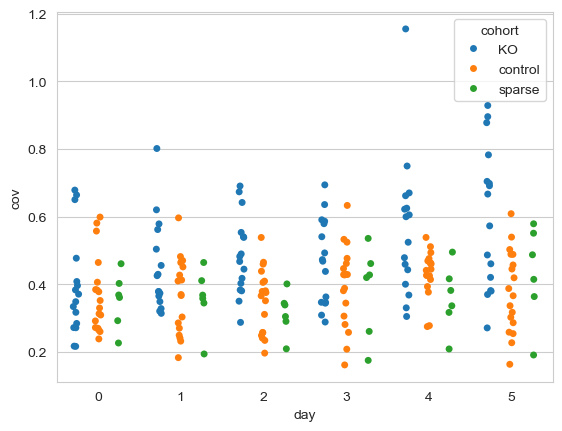

In [44]:
sns.stripplot(data=df_speed, x='day', y='cov', hue='cohort', dodge=True)


In [64]:
lmm_results = smf.mixedlm('cov ~ 1 + C(cohort,Treatment("KO"))*day+nov', groups='mouse',
                          re_formula='~1',
                          data=df_speed,
                          missing='drop').fit(reml=True)
lmm_results.summary()

C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                      MixedLM           Dependent Variable:           cov     
No. Observations:           240               Method:                       REML    
No. Groups:                 20                Scale:                        0.0134  
Min. group size:            12                Log-Likelihood:               142.2320
Max. group size:            12                Converged:                    Yes     
Mean group size:            12.0                                                    
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  0.385    0.031 12.247 0.000  0.323  0.447
C(cohort, Treatment("KO"))[T.control]     -0.033    0.042 -0.778 0.437 -0.115  0.050
C(cohort, Treatment("KO"))[T.sparse]      -0.064    0.058 -1.090 0.276 -0.178  0.051
nov[T.True]                                0.022    0.015  1.467 0.142 -0.007  0.051
day                                        0.039    0.007  5.588 0.000  0.025  0.052
C(cohort, Treatment("KO"))[T.control]:day -0.031    0.010 -3.224 0.001 -0.049 -0.012
C(cohort, Treatment("KO"))[T.sparse]:day  -0.025    0.013 -1.909 0.056 -0.051  0.001
mouse Var                                  0.004    0.016                           
====================================================================================

"""

In [18]:
df_ =df[df['day']<5]
lmm_res = MixedLM(df_['lickrate'], df_[['ko', 
                                       'day_norm', 
                                       'nov', 
                                       'lr', 
                                       'ko_x_day', 
                                       'ko_x_nov', 
                                       'intercept']], df_['mouse'], exog_re = df_['day_norm'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)


# float = continuous, int/string = categories

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lickrate 
No. Observations: 170     Method:             REML     
No. Groups:       17      Scale:              0.5077   
Min. group size:  10      Log-Likelihood:     -203.9642
Max. group size:  10      Converged:          Yes      
Mean group size:  10.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
ko           -0.904    0.280 -3.232 0.001 -1.453 -0.356
day_norm     -0.719    0.512 -1.406 0.160 -1.722  0.284
nov           0.083    0.151  0.549 0.583 -0.213  0.378
lr            0.542    0.111  4.865 0.000  0.323  0.760
ko_x_day     -0.708    0.746 -0.949 0.342 -2.170  0.754
ko_x_nov      0.146    0.223  0.656 0.512 -0.290  0.582
intercept     2.758    0.198 13.948 0.000  2.371  3.146
day_norm Var  1.442    0.865                           



In [4]:
sess = u.load_vr_day(ko_mice[7], 5)

{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:10: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}


<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:10: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invali

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:10: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:10: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:10: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-b3dc6793d03c>:18: RuntimeWarning: Mean of empty slice.
  ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: inval

({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}, {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1})
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:18: RuntimeWarning: Mean of empty slice.
  ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:20: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'red' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:18: RuntimeWarning: Mean of empty slice.
  ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:20: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'red' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-b3dc6793d03c>:18: RuntimeWarning: Mean of empty slice.
  ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invali

{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': -1, 'novel_arm': -1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:18: RuntimeWarning: Mean of empty slice.
  ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:20: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'red' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.0, 0.25)

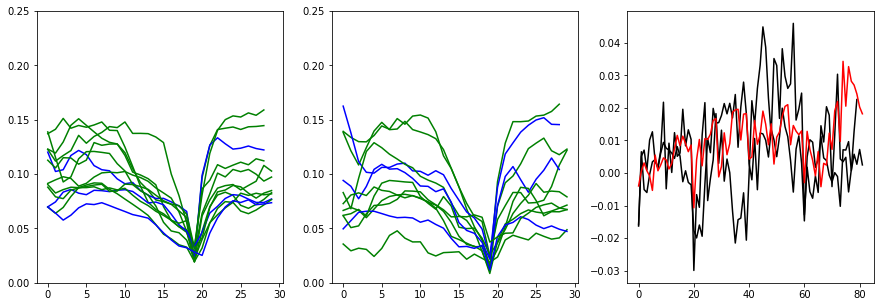

In [14]:
fig,ax = plt.subplots(1,3, figsize=[15,5])

for mouse in ctrl_mice:
    sess = u.load_vr_day(mouse,0)
    left_post = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']>=2)
    ax[0].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=0), color= 'green')
    left_pre = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']<2)
    ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
    
    ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )

    
for mouse in ko_mice:
    sess = u.load_vr_day(mouse,0)
    left_post = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']>=2)
    ax[1].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=0), color= 'green')
    left_pre = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']<2)
    ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
    
    ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'red' )
    
ax[0].set_ylim([0,.25])
ax[1].set_ylim([0,.25])
    

{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}


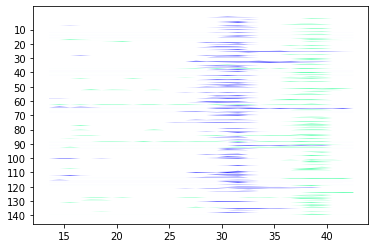

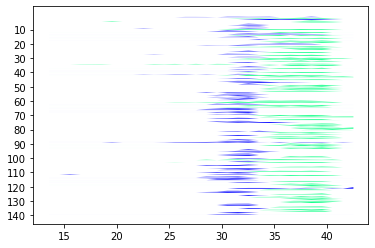

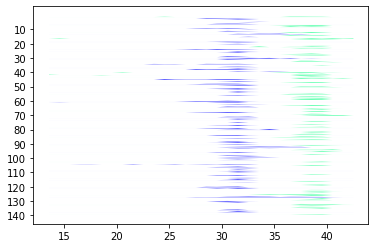

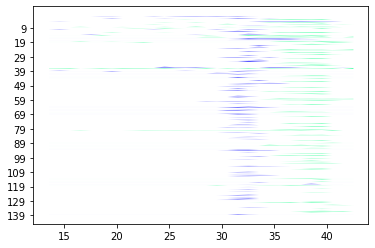

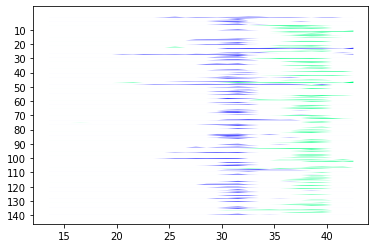

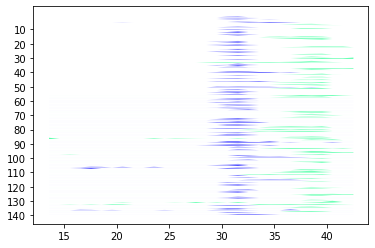

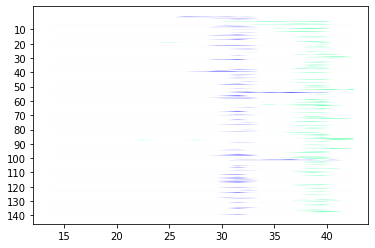

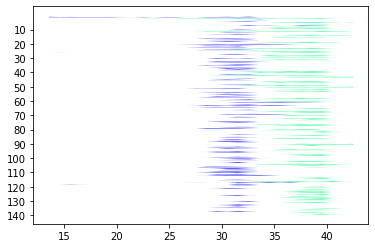

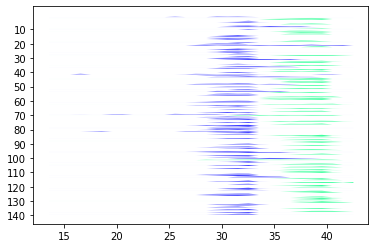

In [18]:
for mouse in ctrl_mice:
    sess = u.load_vr_day(mouse,5)
    
#     fig,ax = plt.subplots()
    fig, ax = tpu.utilities.smooth_raster(sess.trial_matrices['bin_centers'],sess.trial_matrices['licks'],vals = sess.trial_info['LR'],cmap='winter')
    